<a href="https://colab.research.google.com/github/AnonymousStudent22/assessment/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install nltk
#!pip install pandas
#!pip install -U matplotlib
#!pip install numpy
#!pip install -U scikit-learn
#!pip install tensorflow   # installed version 2.2.0 (along with python 3.8.2) on machine
###!pip install --upgrade tensorflow
#!pip install seaborn
#!pip install wordcloud
#!pip install --upgrade gensim
##!pip install -U textblob
#!pip install keras
#!pip install spacytextblob






In [ ]:
import pandas as pd
import numpy as np
import nltk
import re
import gensim
from textblob import TextBlob
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import tensorflow #tensorflow 2.8.0 (with Python 3.7.13)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras import layers
from keras import callbacks
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from keras.layers import SpatialDropout1D
from keras.models import Model
from keras import metrics


from wordcloud import WordCloud
import seaborn as sns
import pprint
import matplotlib.pyplot as plt; plt.rcdefaults()


In [ ]:

dataset = pd.read_csv('dataset/SemEval2017-task4-dev.subtask-A.english.INPUT.txt', 
                       sep='\t',header=None )
#dataset = pd.read_csv('dataset/SemEval2017-undersampled.txt', 
#                       sep='\t',header=None )
#print(dataset.head(5))

dataset.columns = ['id','sentiment','tweet','unknown']
dataset = dataset.drop(['unknown'], axis=1)
dataset = dataset.drop(['id'], axis=1) # dropped id 

dataset


,sentiment,tweet
0,neutral,"Picturehouse's, Pink Floyd's, 'Roger Waters: T..."
1,neutral,Order Go Set a Watchman in store or through ou...
2,negative,If these runway renovations at the airport pre...
3,neutral,If you could ask an onstage interview question...
4,positive,A portion of book sales from our Harper Lee/Go...
...,...,...
20627,neutral,@ShaquilleHoNeal from what I think you're aski...
20628,positive,"Iran ranks 1st in liver surgeries, Allah bless..."
20629,neutral,Hours before he arrived in Saudi Arabia on Tue...
20630,negative,@VanityFair Alex Kim Kardashian worth how to ...


####**Remove duplicates** 


In [ ]:
# REMOVE DUPLICATES
'''

myDict = dict()

# In a dictionary, save id to index and increment its value by 
# 1 if a duplicate is found
for index, row in dataset.iterrows():
    if row["id"] not in myDict.keys():
        myDict[row["id"]] = 1        
    else:
        myDict[row["id"]] += 1

# Create a dictionary of duplicates just to show what will later be removed       
dups = {key:value for (key, value) in myDict.items() if value > 1}
pprint.pprint(dups)
print(len(dups), 'duplicates to be removed')

        
# remove duplicates from dataset
dataset.drop_duplicates(keep='first', inplace=True)

# write to dataset text to file just to check that duplicates have been removed
# dataset.to_csv(r'input_deduped.txt', header=None, index=None, sep='\t', mode='a')

'''

'\n\nmyDict = dict()\n\n# In a dictionary, save id to index and increment its value by \n# 1 if a duplicate is found\nfor index, row in dataset.iterrows():\n    if row["id"] not in myDict.keys():\n        myDict[row["id"]] = 1        \n    else:\n        myDict[row["id"]] += 1\n\n# Create a dictionary of duplicates just to show what will later be removed       \ndups = {key:value for (key, value) in myDict.items() if value > 1}\npprint.pprint(dups)\nprint(len(dups), \'duplicates to be removed\')\n\n        \n# remove duplicates from dataset\ndataset.drop_duplicates(keep=\'first\', inplace=True)\n\n# write to dataset text to file just to check that duplicates have been removed\n# dataset.to_csv(r\'input_deduped.txt\', header=None, index=None, sep=\'\t\', mode=\'a\')\n\n'

<BarContainer object of 3 artists>

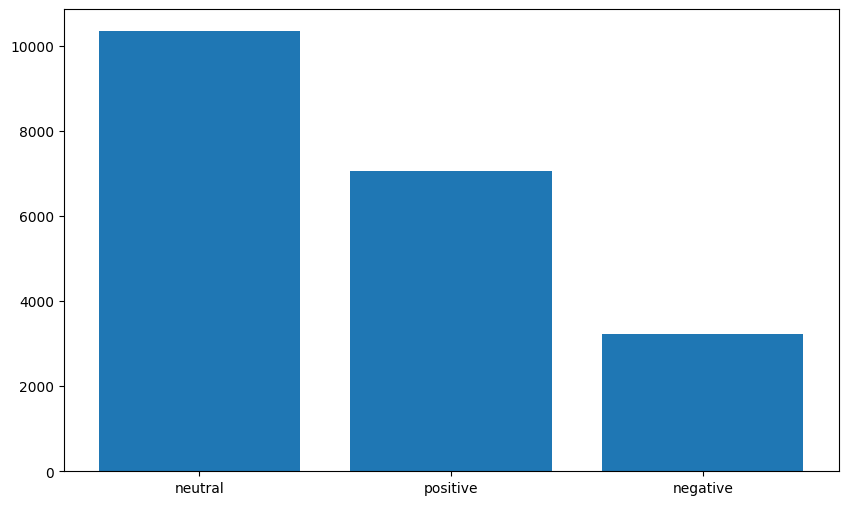

In [ ]:
distribution = dataset.sentiment.value_counts() # value_counts() is a pandas function
plt.figure(figsize=(10,6))
plt.bar(distribution.index, distribution.values)


In [ ]:
#Encode labels neutral=1, negative=0,positive=2
label=LabelEncoder()
dataset['sentiment'] = label.fit_transform(dataset['sentiment'])

# check the updated labels
dataset


,sentiment,tweet
0,1,"Picturehouse's, Pink Floyd's, 'Roger Waters: T..."
1,1,Order Go Set a Watchman in store or through ou...
2,0,If these runway renovations at the airport pre...
3,1,If you could ask an onstage interview question...
4,2,A portion of book sales from our Harper Lee/Go...
...,...,...
20627,1,@ShaquilleHoNeal from what I think you're aski...
20628,2,"Iran ranks 1st in liver surgeries, Allah bless..."
20629,1,Hours before he arrived in Saudi Arabia on Tue...
20630,0,@VanityFair Alex Kim Kardashian worth how to ...


####**Pre-process the Data** 


In [ ]:
# Convert to lowercase, remove punctuation, noise, such as non-alphanumeric characters, 
# urls, and double white spaces. Remove stopwords

# Downloads needed when running script on browser
nltk.download('punkt') 
nltk.download('averaged_perceptron_tagger') 
nltk.download('wordnet')

def preprocess(tweet): 
    
    tweet = re.sub(r"[Ww]on't","willn't", str(tweet))# 1st step to expand "won't"
    tweet = re.sub(r"n't",' not', str(tweet)) # expand negative contractions
    tweet = re.sub(r"'s",'s' , str(tweet)) # remove apotrophe in possessives, but keep 's'
    tweet = re.sub(r"(@\S+|#\S+)",' ',str(tweet)) #remove hashtags and users: @ and #
    tweet = re.sub(r"\s\s+",' ',str(tweet)) # replace more than two spaces with one
    tweet = re.sub(r"([^a-zA-z0-9]+|https?:\S+)",' ',str(tweet).lower()).strip() #remove urls
    
    sent = TextBlob(tweet) # lemmatize text
    tag_dict = {"JJ": 'a', 
                "NN": 'n', 
                "V":  'v', 
                "R":  'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'a')) for w, pos in sent.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    tweet =  " ".join(lemmatized_list)
    tweet = remove_stopwords(tweet) # remove stopwords (to be done after lemmatizing)


    
    return tweet

# Use lambda to run preprocess function on each row of the dataset tweets
dataset.tweet = dataset.tweet.apply(lambda x: preprocess(x))
#print(dataset.tweet)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

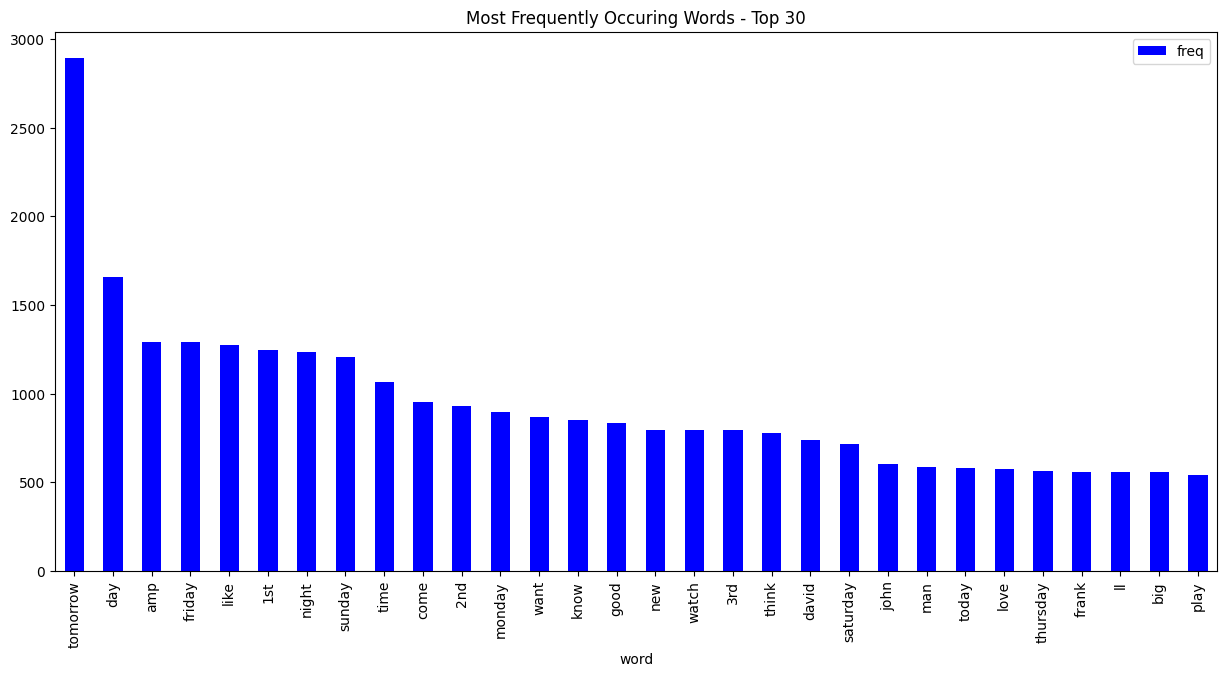

In [ ]:
# Gather stopwords

tweets = dataset.tweet  # extract tweets only
vectorizer = CountVectorizer(stop_words = 'english') #
words = vectorizer.fit_transform(tweets) ## stopwords are extracted from training data instead of nltk


sum_words = words.sum(axis=0)

word_freq = [(word, sum_words[0, i]) for word, i in vectorizer.vocabulary_.items()]
word_freq = sorted(word_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(word_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")


In [ ]:
#explore lengths of tweets and plot them by length?

tweet_lengths = []
for index, row in dataset.iterrows():
    tweet_lengths.append(len(row['tweet']))

#for i in tweet_lengths:
    #print(i)   # lengths are 1-158

#print(len(tweet_lengths))

 






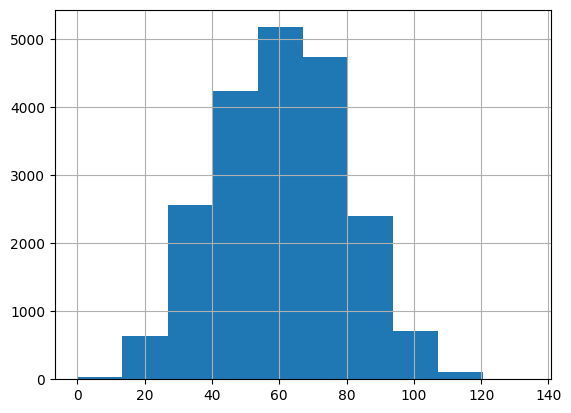

count    20632.000000
mean        60.638765
std         19.005389
min          0.000000
25%         47.000000
50%         61.000000
75%         74.000000
max        134.000000
dtype: float64

In [ ]:
#rev_len = [len(i) for i in x_train]
pd.Series(tweet_lengths).hist()
plt.show()
pd.Series(tweet_lengths).describe()

Text(0.5, 1.0, 'Vocabulary from Tweets')

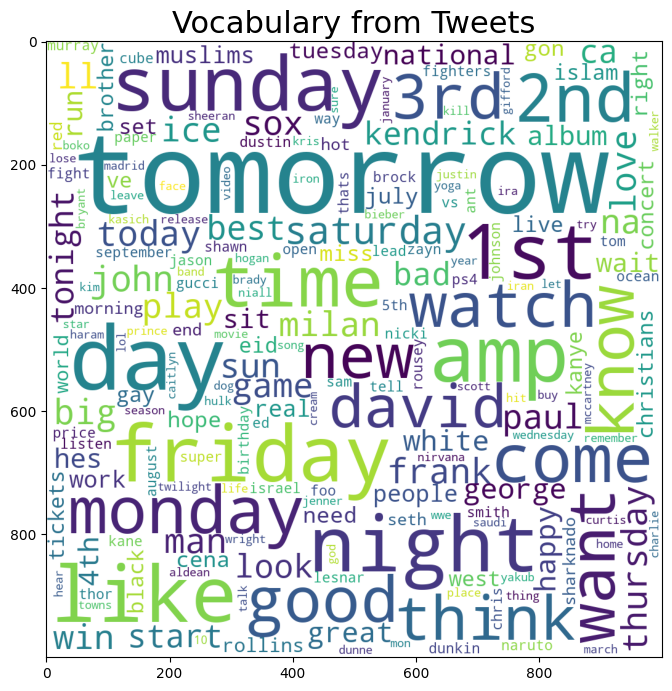

In [ ]:

wordcloud = WordCloud(background_color = 'white', width = 1000, 
                      height = 1000).generate_from_frequencies(dict(word_freq))

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title("Vocabulary from Tweets", fontsize = 22)

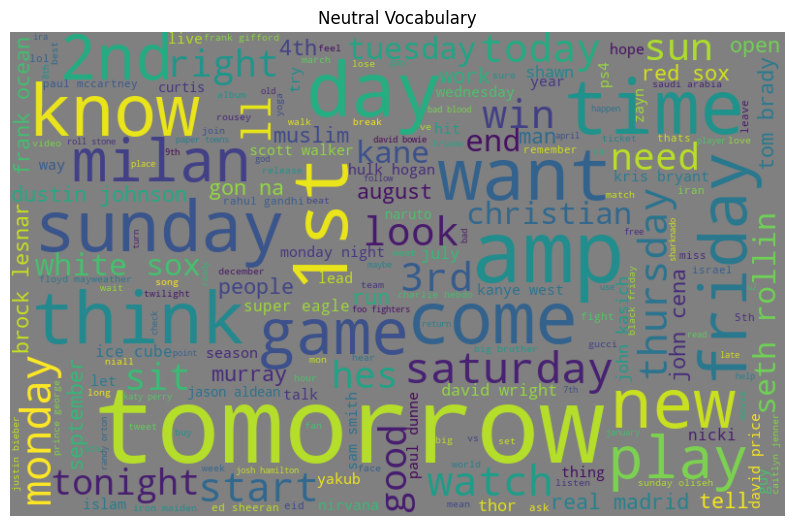

In [ ]:
neutral_vocab =' '.join([text for text in dataset['tweet'][dataset['sentiment'] == 1]])

wordcloud = WordCloud(background_color = 'grey', width=800, height=500, 
                      random_state = 0, max_font_size = 110).generate(neutral_vocab)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Neutral Vocabulary')
plt.show()

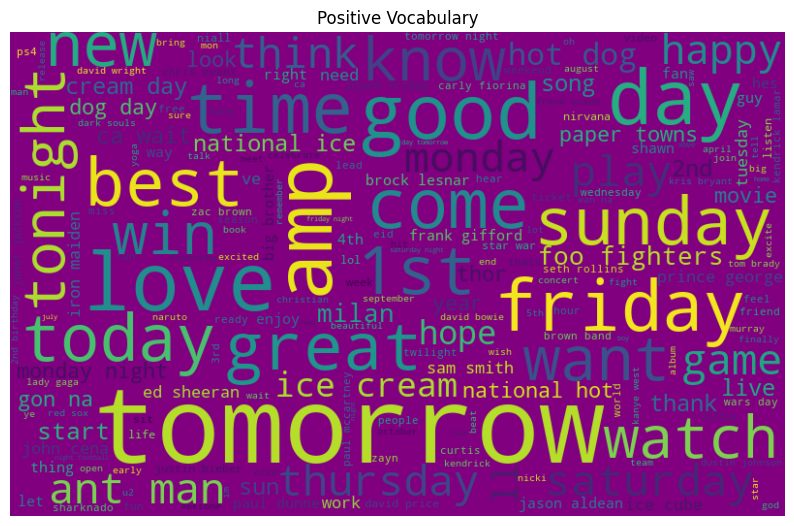

In [ ]:
positive_vocab =' '.join([text for text in dataset['tweet'][dataset['sentiment'] == 2]])

wordcloud = WordCloud(background_color = 'purple', width=800, height=500, 
                      random_state = 0, max_font_size = 110).generate(positive_vocab)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Positive Vocabulary')
plt.show()

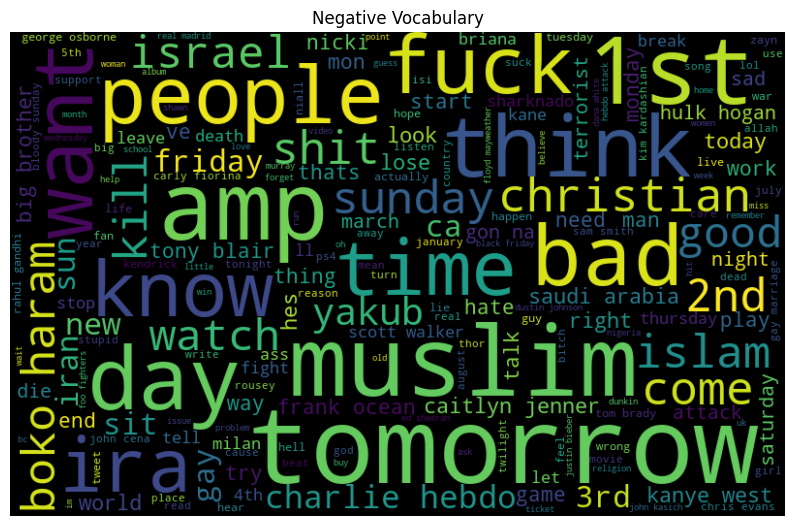

In [ ]:
negative_vocab =' '.join([text for text in dataset['tweet'][dataset['sentiment'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state = 1, 
                      max_font_size = 110).generate(negative_vocab)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Negative Vocabulary')
plt.show()

##Create Word Index and Embeddings


In [ ]:


def build_word_index(data):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data)
    word_index = tokenizer.word_index # dictionary mapping each word to an integer
    
    return word_index
    
#word_to_int= build_word_index(dataset['tweet'])
word_to_int= build_word_index(dataset.tweet)

# Check that mapping looks right
print(word_to_int)
print('length of word_to_int',len(word_to_int))
print(word_to_int['day'])
print(word_to_int['friday'])


    

{'tomorrow': 1, 'day': 2, 'amp': 3, 'friday': 4, 'm': 5, 'like': 6, '1st': 7, 'night': 8, 'sunday': 9, 'time': 10, 'come': 11, '2nd': 12, 'monday': 13, 'want': 14, 'know': 15, 'good': 16, '2': 17, 'new': 18, 'watch': 19, '3rd': 20, 'think': 21, 'david': 22, 'saturday': 23, '3': 24, 'john': 25, 'man': 26, 'today': 27, '1': 28, 'love': 29, 'thursday': 30, 'frank': 31, 'll': 32, 'big': 33, 'play': 34, 'win': 35, 'milan': 36, 'sun': 37, 'ice': 38, 'game': 39, 'sox': 40, 'paul': 41, 'na': 42, 'best': 43, 'look': 44, '4': 45, 'start': 46, 'tonight': 47, 'ca': 48, 'bad': 49, 'kendrick': 50, 'george': 51, 'happy': 52, 'great': 53, 'white': 54, 'national': 55, '4th': 56, '5': 57, 'album': 58, 'run': 59, 'hes': 60, 'sit': 61, 'wait': 62, 'people': 63, 'u': 64, 'work': 65, 'muslims': 66, 'real': 67, 'tuesday': 68, 'need': 69, 'miss': 70, 'gon': 71, 'hope': 72, 'right': 73, 'july': 74, 'cena': 75, 'christians': 76, 'concert': 77, 'eid': 78, 'kanye': 79, 'brother': 80, 'set': 81, 'west': 82, 'live'

In [ ]:
def build_embeddings(word_dict):
    embeddings_dict = {}
    # Open the glove embeddings text file
    file = open('sample_data/glove.6B.300d.txt')
    for line in file:
        # Read in each line, split words add to a list
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_dict[word] = vector
    file.close()
    print('Found %s word vectors.' %len(embeddings_dict))
    
    vocab_size = len(word_dict) + 1
    # creating a matrix with zeroes of shape vocab x embedding dimension
    embedding_matrix = np.zeros((vocab_size, 300)) #each embedding vector is of length 300
    # Iterate through word, index in the dictionary
    for word, i in word_dict.items():
       # use word from word_dict to search for its corresponding vector in embeddings
        embedding_vector = embeddings_dict.get(word) 
        if embedding_vector is not None:
            # Storing it in a matrix
            embedding_matrix[i] = embedding_vector 
    return embedding_matrix,embeddings_dict,vocab_size

embeddings,embeddings_dict,vocab_size = build_embeddings(word_to_int)

#Check that mappings look right
#print('embedding_matrix for int 7, which corresponds to "friday"',embeddings[7])
#print('embedding_dict vector for "friday"',embeddings_dict['friday'])

#Verify that the vectors for integer 7 are equal to those for 'Friday'
if list(embeddings[7]) == list(embeddings_dict['friday']):
    print('True')




Found 33987 word vectors.


In [ ]:
# build word dictionary based on word_index and 
#pass them into the padded sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset.tweet)
word_index = tokenizer.word_index

#print(word_index)
#print(word_to_int)



#### **Split data into training and testing**



In [ ]:


# Splitting the data into training and testing sets
#dataset = shuffle(dataset)
train_data, test_data = train_test_split(dataset, test_size=0.2,random_state=16)


print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

print(type(train_data)) # still a pandas object
print(type(test_data)) # still a pandas object

# check that the train_data looks ok
train_data.tweet

Train Data size: 16505
Test Data size 4127
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


6116                           christ paper towns tomorrow
1207     want sharknado 3 record dvd tomorrow bring tra...
3289     daddy daughter dunkin date hit mommy twice 1st...
6583     guy sit look like hulk hogan waist toothpick l...
5800     gop candatidates eligable prison 1 drop chris ...
                               ...                        
17729    begin feel little offend loki like report thor...
581      paul dunne par 13th stay 11 jordan spieth shor...
2169     fear dead bomb blast rock crowded sunday marke...
15598    review seth rollins sting amp statue best segm...
6825          gt gt david wright return mets monday philly
Name: tweet, Length: 16505, dtype: object

In [ ]:
# This is a test to prove that texts_to_sequences works. Encoding tweets 1-10 into integers
# with texts_to_sequences(), and then decoding them my_int_to_word
# The decoded text is difficult to read as there's no sentence boundary (should there be?)
# and all punctuation is removed. It becomes even more difficult if the data has been lemmatised

'''
t = Tokenizer()
myText=train_data.tweet[0:10]
t.fit_on_texts(myText)
myIndex = t.word_index
mySeq=t.texts_to_sequences(myText)
print(mySeq)
my_int_to_word = {v: k for k, v in myIndex.items()} # to decode integer sequences

#print(my_int_to_word)   


flat_list = [item for sublist in mySeq for item in sublist]
#print(flat_list)
for i in flat_list:
 print("decoded tweets: ",my_int_to_word[i])
print("tweets from dataset:",train_data.tweet[0:10])
'''


'\nt = Tokenizer()\nmyText=train_data.tweet[0:10]\nt.fit_on_texts(myText)\nmyIndex = t.word_index\nmySeq=t.texts_to_sequences(myText)\nprint(mySeq)\nmy_int_to_word = {v: k for k, v in myIndex.items()} # to decode integer sequences\n\n#print(my_int_to_word)   \n\n\nflat_list = [item for sublist in mySeq for item in sublist]\n#print(flat_list)\nfor i in flat_list:\n print("decoded tweets: ",my_int_to_word[i])\nprint("tweets from dataset:",train_data.tweet[0:10])\n'

#### **Split training and testing into input data (features) and target data (labels)**

In [ ]:
# Create placeholders for padded sequences of length 90 

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.tweet),maxlen = 60)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.tweet),maxlen = 60)

# Create target data for training and testing
y_train = train_data.sentiment
y_test = test_data.sentiment


#print(type(x_train)) # not a pandas object anymore, but an array
#print(type(y_train)) # still a pandas object

# convert target data into array
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# reshape from 1D to 2D
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1,1)

print("y_train type",type(y_train))
print("y_test type",type(y_test))
print("x_train type",type(x_train))
print("x_train type",type(x_train))

print('x_train shape',x_train.shape)
print('y_train shape',y_train.shape)
print('x_test shape',x_test.shape)
print('y_test shape',y_test.shape)


y_train type <class 'numpy.ndarray'>
y_test type <class 'numpy.ndarray'>
x_train type <class 'numpy.ndarray'>
x_train type <class 'numpy.ndarray'>
x_train shape (16505, 60)
y_train shape (16505, 1)
x_test shape (4127, 60)
y_test shape (4127, 1)


####**Define the model** 

In [ ]:

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D




model = Sequential()
model.add(layers.Embedding(vocab_size,300,weights=[embeddings], input_length = 60))

#model.add(embedding_layer)
model.add(SpatialDropout1D(0.4)) 
model.add(LSTM(64, activation='relu', return_sequences=True,dropout=0.2, recurrent_dropout=0.2)) # (previously 176)
model.add(LSTM(128,activation='relu', return_sequences=True)) # originally 128
model.add(LSTM(128,activation='relu'))
model.add(Dense(3,activation='softmax')) # 3 classes will be output
opt = Adam(learning_rate=0.01)
#sparse_categorical_crossentropy replaced categorical_crossentropy
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 300)           6115800   
                                                                 
 spatial_dropout1d (SpatialD  (None, 60, 300)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 60, 64)            93440     
                                                                 
 lstm_1 (LSTM)               (None, 60, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                        

In [ ]:
reduce_lr = ReduceLROnPlateau(factor=0.1,min_lr = 0.0000001, monitor = 'val_loss',verbose = 1) #to reduce learning rate when a metric has stopped improving.
es = callbacks.EarlyStopping(monitor='loss', patience=3)
batch_size=60
model.fit(x_train, y_train, epochs = 500, batch_size=batch_size, callbacks=[reduce_lr,es],validation_data=(x_test, y_test),verbose=True)



Epoch 1/500
276/276 [==============================] - 122s 418ms/step - loss: 79766.7109 - accuracy: 0.5699 - val_loss: 0.8244 - val_accuracy: 0.6346 - lr: 0.0100
Epoch 2/500
276/276 [==============================] - 116s 420ms/step - loss: 0.7641 - accuracy: 0.6636 - val_loss: 0.7844 - val_accuracy: 0.6537 - lr: 0.0100
Epoch 3/500
276/276 [==============================] - 115s 416ms/step - loss: 0.6028 - accuracy: 0.7504 - val_loss: 0.8216 - val_accuracy: 0.6278 - lr: 0.0100
Epoch 4/500
276/276 [==============================] - 114s 414ms/step - loss: 0.4844 - accuracy: 0.8101 - val_loss: 0.8718 - val_accuracy: 0.6312 - lr: 0.0100
Epoch 5/500
276/276 [==============================] - 114s 414ms/step - loss: 0.4096 - accuracy: 0.8464 - val_loss: 0.8867 - val_accuracy: 0.6327 - lr: 0.0100
Epoch 6/500
276/276 [==============================] - 115s 415ms/step - loss: 0.3520 - accuracy: 0.8686 - val_loss: 1.0609 - val_accuracy: 0.6130 - lr: 0.0100
Epoch 7/500
276/276 [===============

In [ ]:

# Evaluate the model on the test data using `evaluate`
# current results: test loss, test acc: [1.0018061430731646, 0.5018216967582703]
# results with tanh and sigmoid: val_loss: 1.4862 - val_accuracy: 0.5025
# results with tanh and softmax: val_loss: 2.1204 - val_accuracy: 0.4996
#loss, test acc: [1.0983806536854512, 0.5093287825584412
# 50 epochs/layers at 64 and 128 units: loss, test acc: [1.0747869047091434, 0.5093287825584412]
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=500)
print("test loss, test acc:", results)


Evaluate on test data
9/9 [==============================] - 0s 32ms/step - loss: 1.6502 - accuracy: 0.6096
test loss, test acc: [1.6502141952514648, 0.609643816947937]


              precision    recall  f1-score   support

    negative       0.47      0.39      0.43       641
     neutral       0.65      0.67      0.66      2102
    positive       0.60      0.62      0.61      1384

    accuracy                           0.61      4127
   macro avg       0.57      0.56      0.57      4127
weighted avg       0.61      0.61      0.61      4127



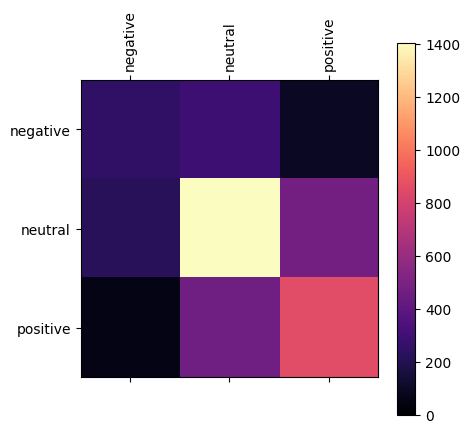

In [ ]:

from sklearn.metrics import classification_report

labels = {'negative':0,'neutral':1, 'positive':2}

# given trained model `model` and test vector 'x_test' gives 'y_test'
# where 'y_test' and 'y_predicted' are integers, whose labels are indexed in 
# 'labels'
y_predicted = tensorflow.argmax(model.predict(x_test), axis=1)

# Confusion matrix
cf = tensorflow.math.confusion_matrix(y_test, y_predicted)
plt.matshow(cf, cmap='magma')
plt.colorbar()
plt.xticks(np.arange(len(labels)), labels=labels, rotation=90)
plt.yticks(np.arange(len(labels)), labels=labels)
plt.clim(0, None)

# Report
print(classification_report(y_test, y_predicted, target_names=labels))